In [4]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os

from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [8, 6]
from metavision_core.event_io import RawReader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load recordings from the dataset


In [5]:
from dataset import load_dir

raws_loaded = load_dir('uvled_freq_dataset/recordings/')

raws_loaded.keys()

dict_keys(['20k', '__25Hz', '2.5k', '__100Hz', '5k', '__50Hz', '10k', '1k', '__10Hz', '30k', '__250Hz', '__500Hz'])

### Locate the UV LEDs in the data

In [ ]:
from copy import copy

__freqs = ["1k", "2.5k", "5k", "10k"]

raws = {k: raws_loaded[k] for k in __freqs}

boxes = {k: copy(v) for k, v in raws.items()}

from util import find_bounding_boxes
from dataset import apply

apply(find_bounding_boxes, boxes, delta_t=2000, start_ts=1e6)
apply(lambda x: x[0], boxes)

print(raws["2.5k"])

{'1k': {'1_5': [([], array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)), ([], array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)), ([], array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)), ([], array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0

In [77]:
combined = {}
for freq in __freqs:
	combined[freq] = {}
	for dist in raws[freq]:
		#print(f"Processing {freq} {dist}")
		#print(f"boxes: {boxes[freq][dist]}")
		combined[freq][dist] = []
		for r in range(len(raws[freq][dist])):
			combined[freq][dist].append((raws[freq][dist][r], boxes[freq][dist][r]))
		#print(boxes[freq][dist])
		#combined[freq][dist] = [(r, b) for (r, b) in zip(raws[freq][dist], boxes[freq][dist])]

# Print specific example
#print(combined['2.5k']["0_5"][1])

from util import filter_raw

# Pass a list containing the tuple to filter_raws
#filtered = filter_raws([combined['2.5k']["0_5"][1]])

# Print filtered events
#print(filtered)

apply(filter_raw, combined)
apply(lambda x: x[0], combined)

In [ ]:
from plotting import visualize_data_events

print(combined["2.5k"]["0_5"][0])

In [ ]:
from util import resample_by_polarity

signal = resample_by_polarity(raws['1k']["0_5"][0])

# save this signal to a text file

import numpy as np

np.savetxt('signal.txt', signal, fmt='%d')

### Filter only the important events that are located inside of the bounding boxes

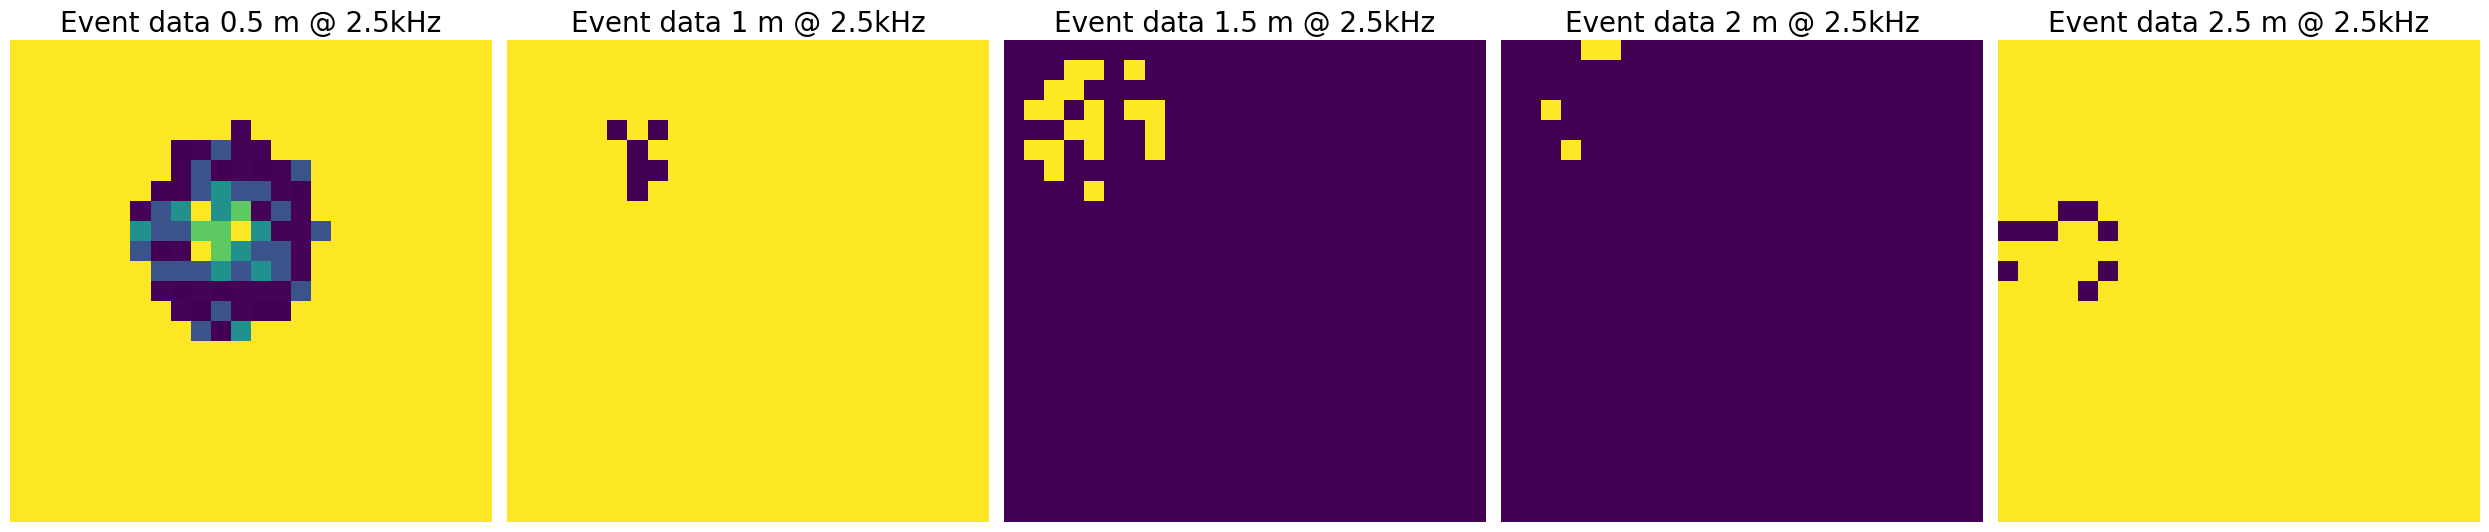

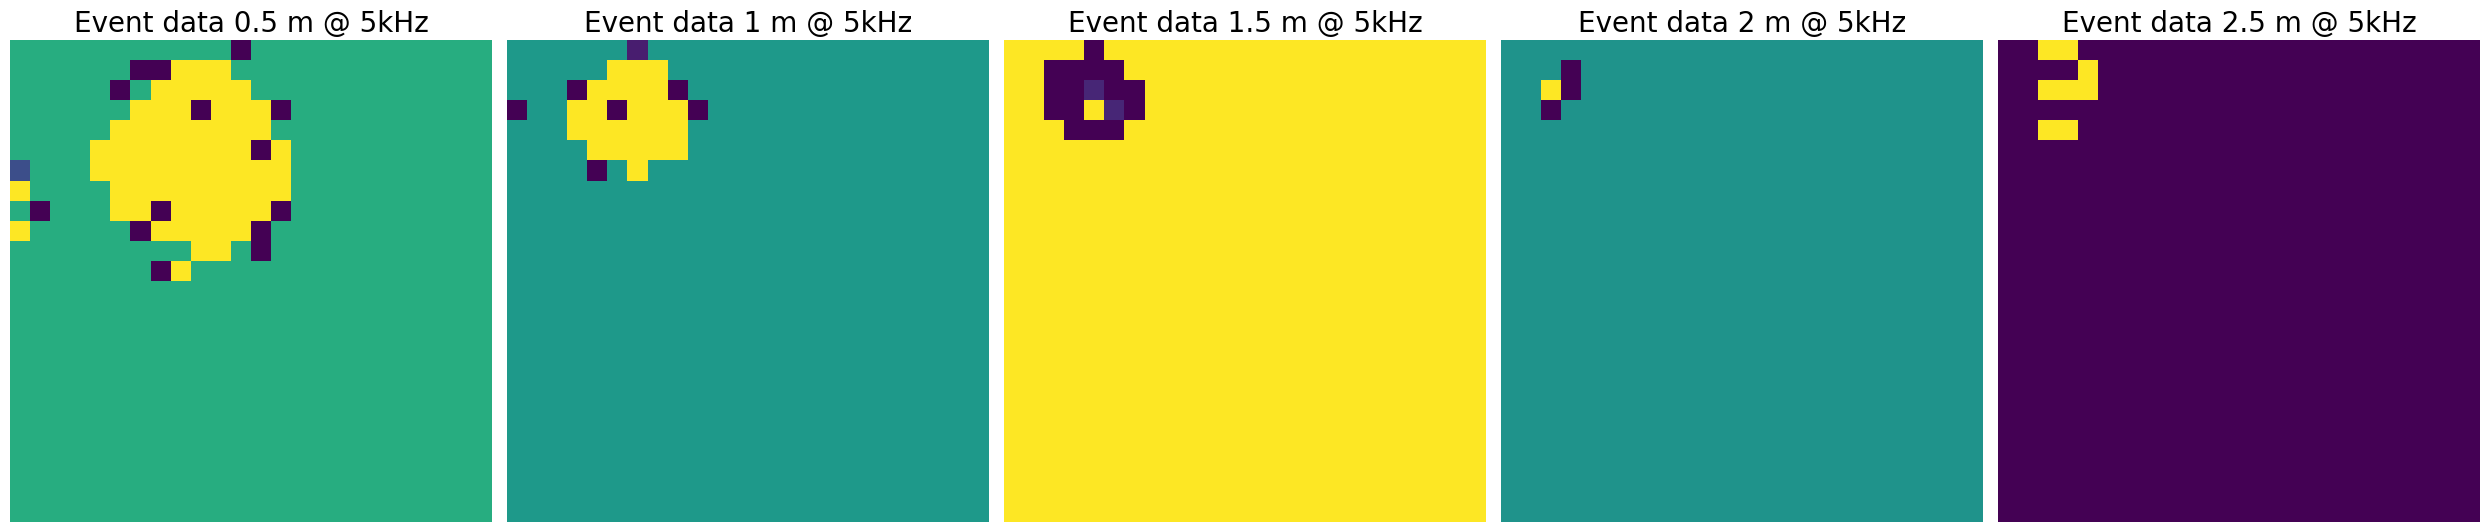

In [7]:
from util import filter_raws, move_events
from plotting import visualize_data_events

#bounding boxes need to be passed as an array
__f_2_5k = [(r, [bb_2_5k[i]]) for i, r in enumerate(raws_2_5k)]
__f_5k = [(r, [bb_5k[i]]) for i, r in enumerate(raws_5k)]

f_events_2_5k = filter_raws(__f_2_5k)
f_events_5k = filter_raws(__f_5k)

f_events_2_5k = [move_events(e) for e in f_events_2_5k]
f_events_5k = [move_events(e) for e in f_events_5k]

visualize_data_events(f_events_2_5k, lables_2_5k)
visualize_data_events(f_events_5k, lables_5k)

### Frequency analysis demo

In [8]:
from metavision_sdk_analytics import DominantFrequencyEventsAlgorithm

min_freq = 100
max_freq = 30000
freq_precision=10
min_count = 0

dominant_freq_algo = DominantFrequencyEventsAlgorithm(frequency_precision = freq_precision, min_frequency = min_freq, max_frequency = max_freq, min_count = min_count)

r = raws_5k[0]
r.reset()
evs = r.load_n_events(150000)

# print(evs.shape)
# print(evs.dtype)

print(f"Frequency: {dominant_freq_algo.compute_dominant_value(evs)[1]} Hz")


Frequency: 24220.0 Hz


### Analyze the LEDs

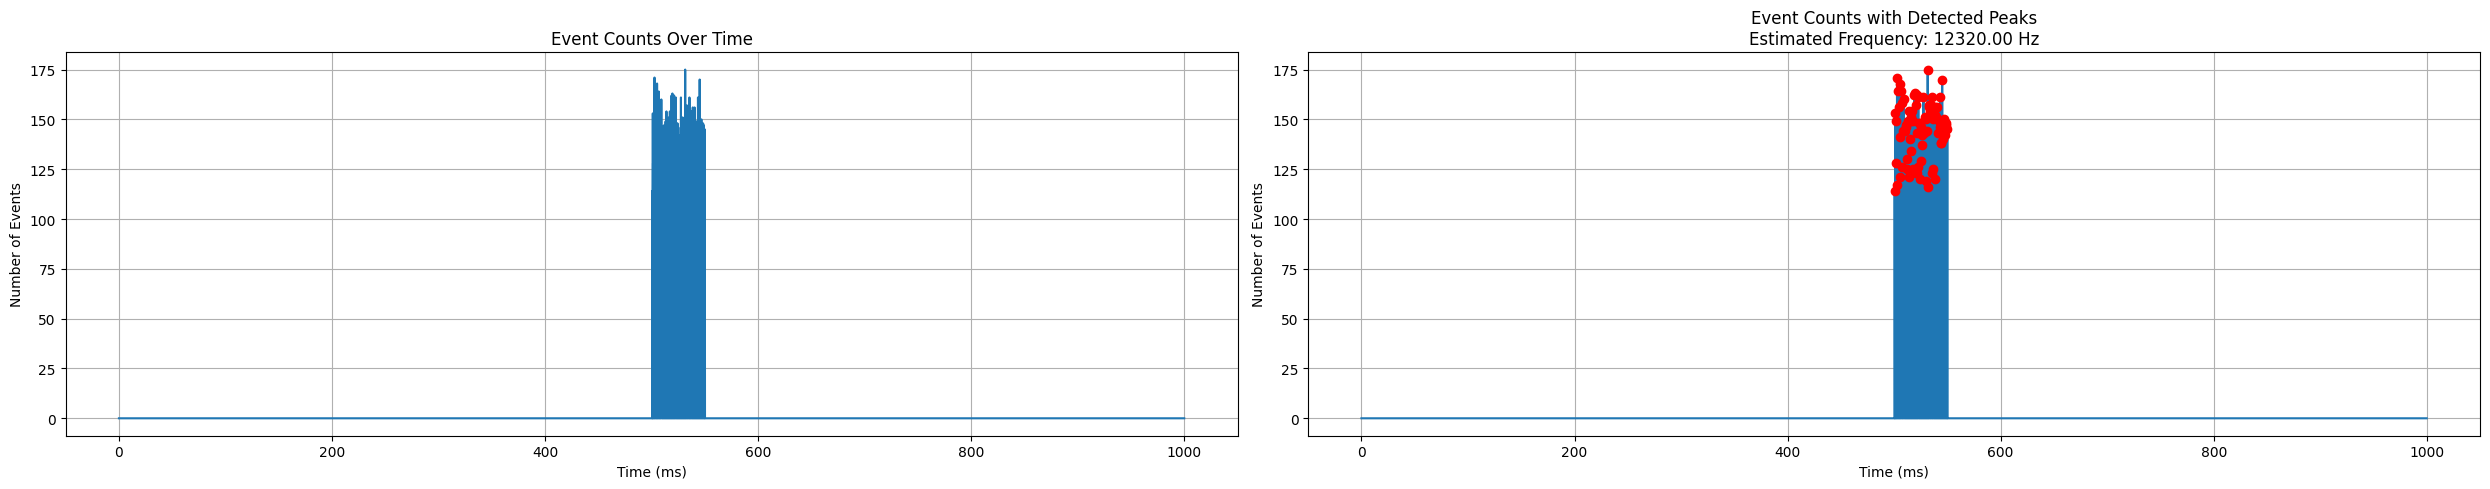

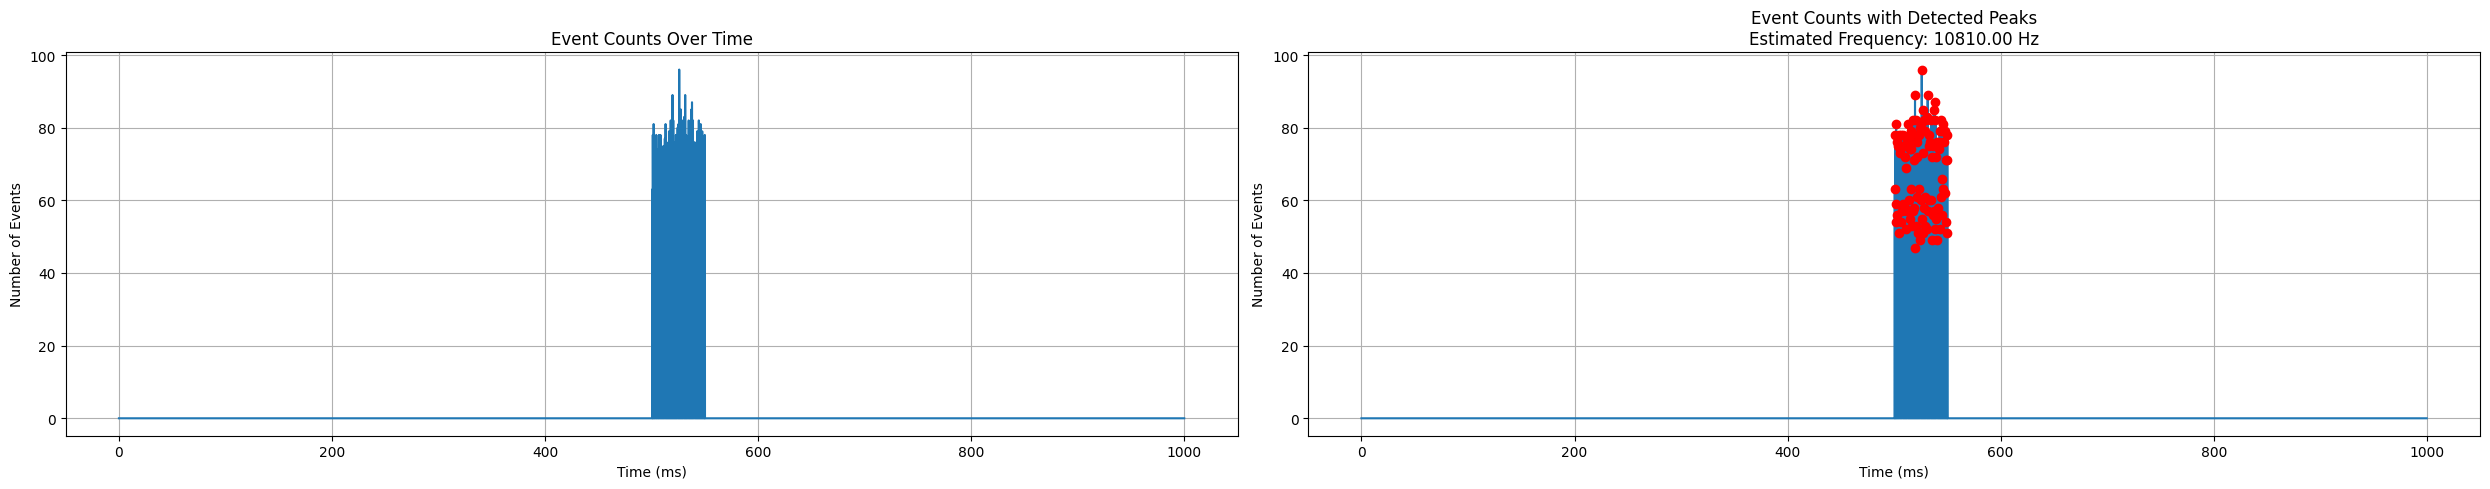

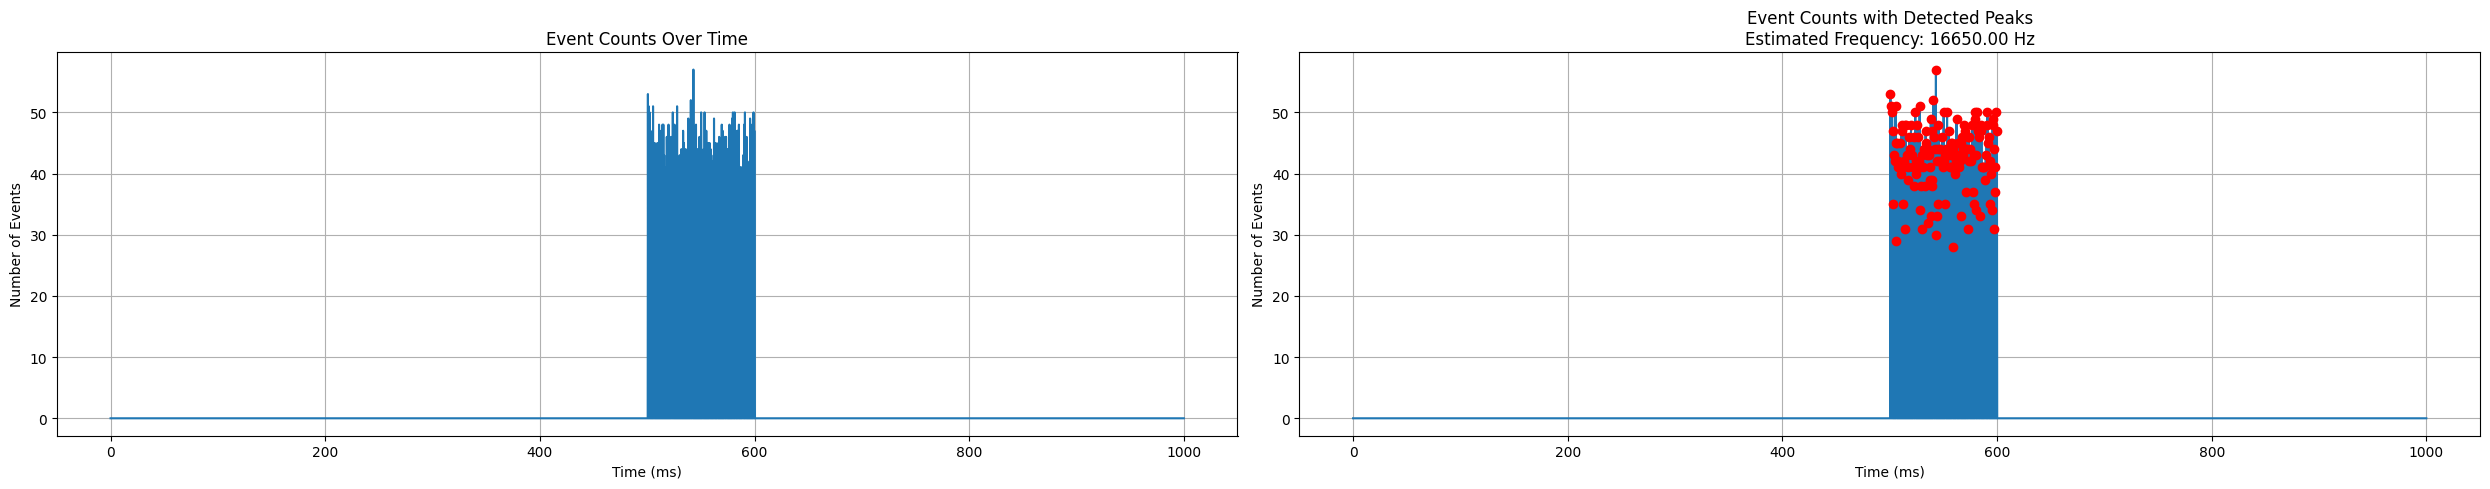

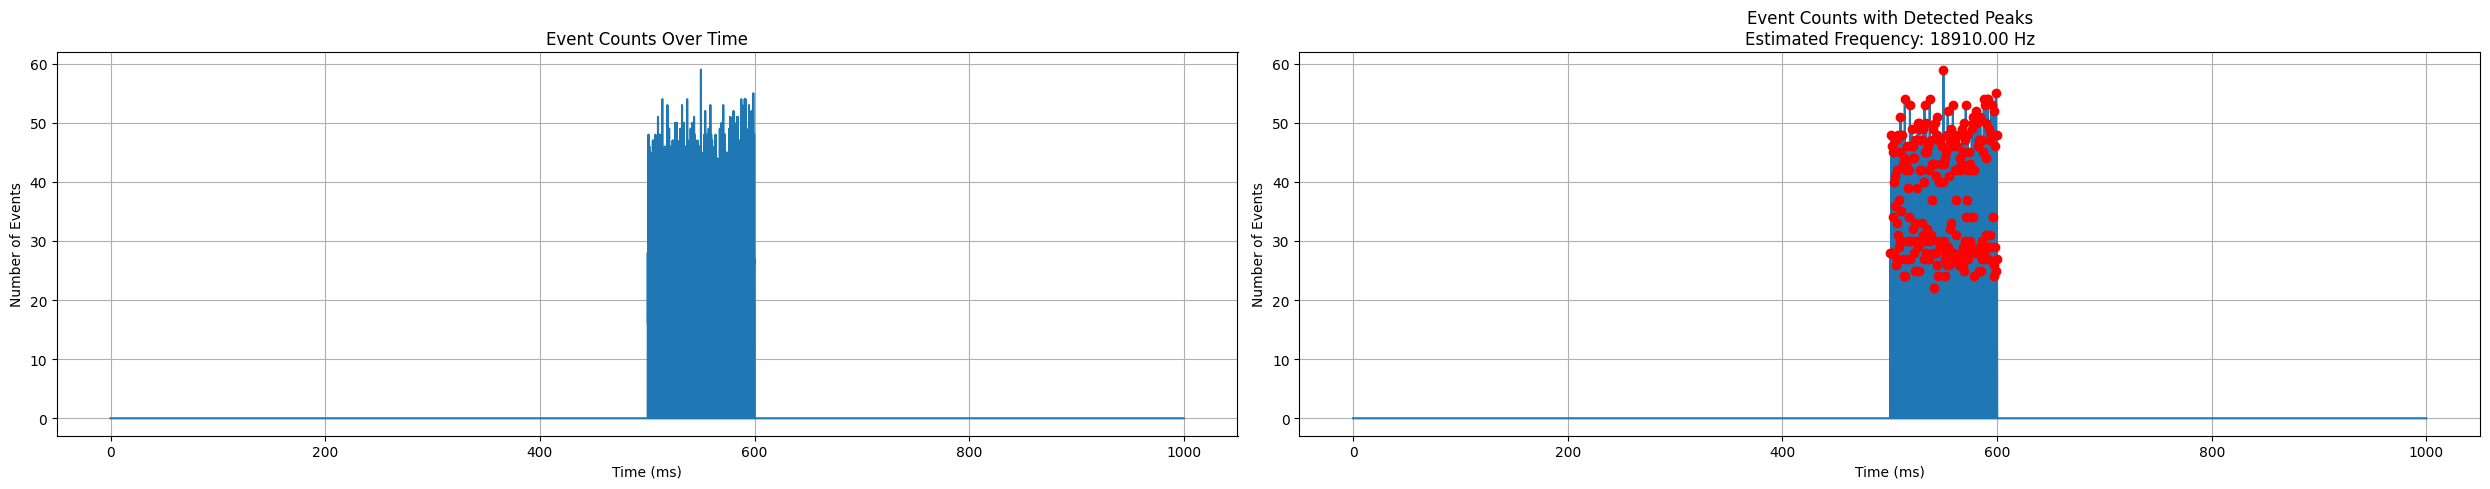

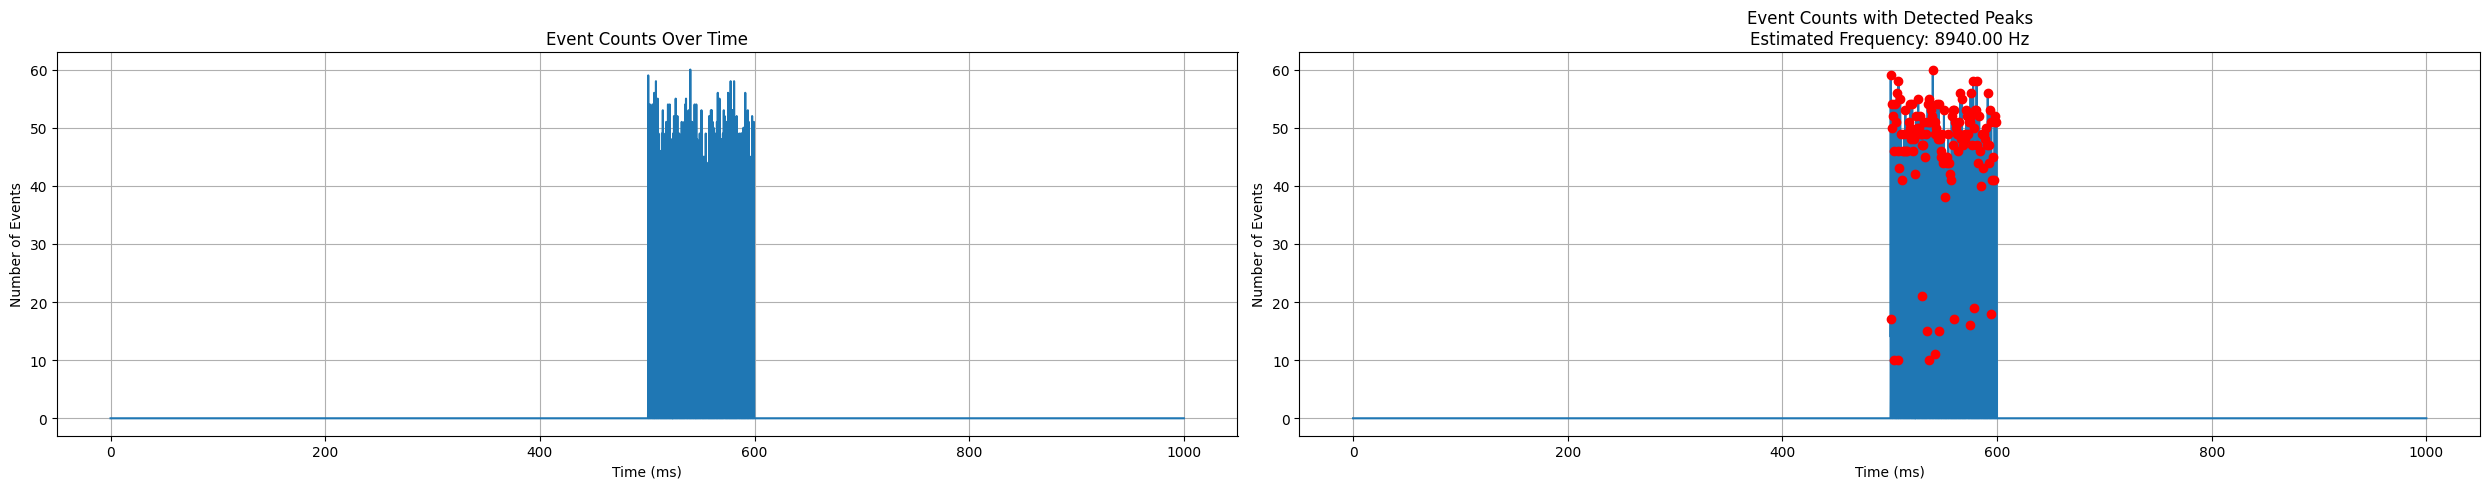

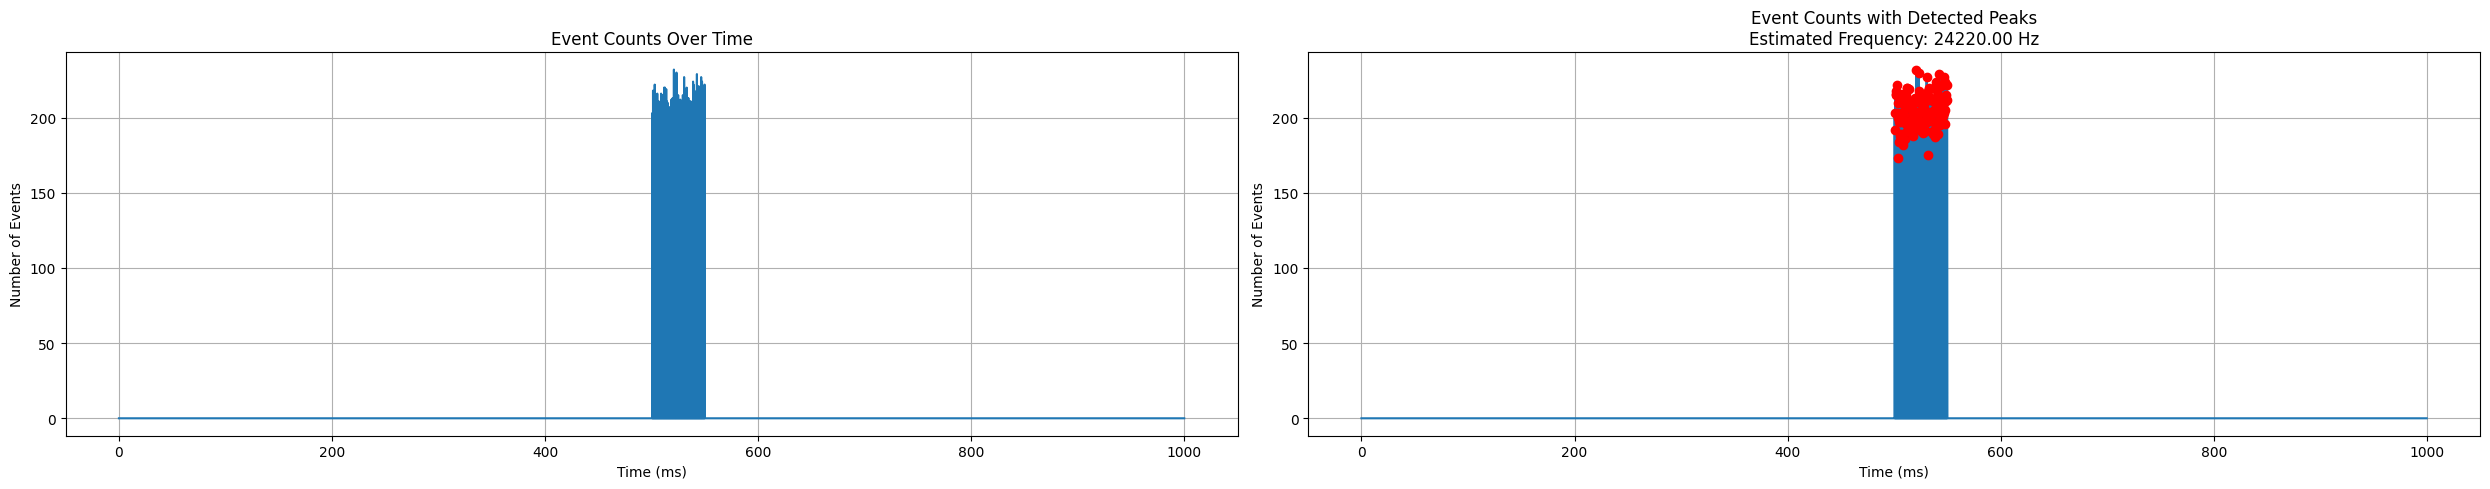

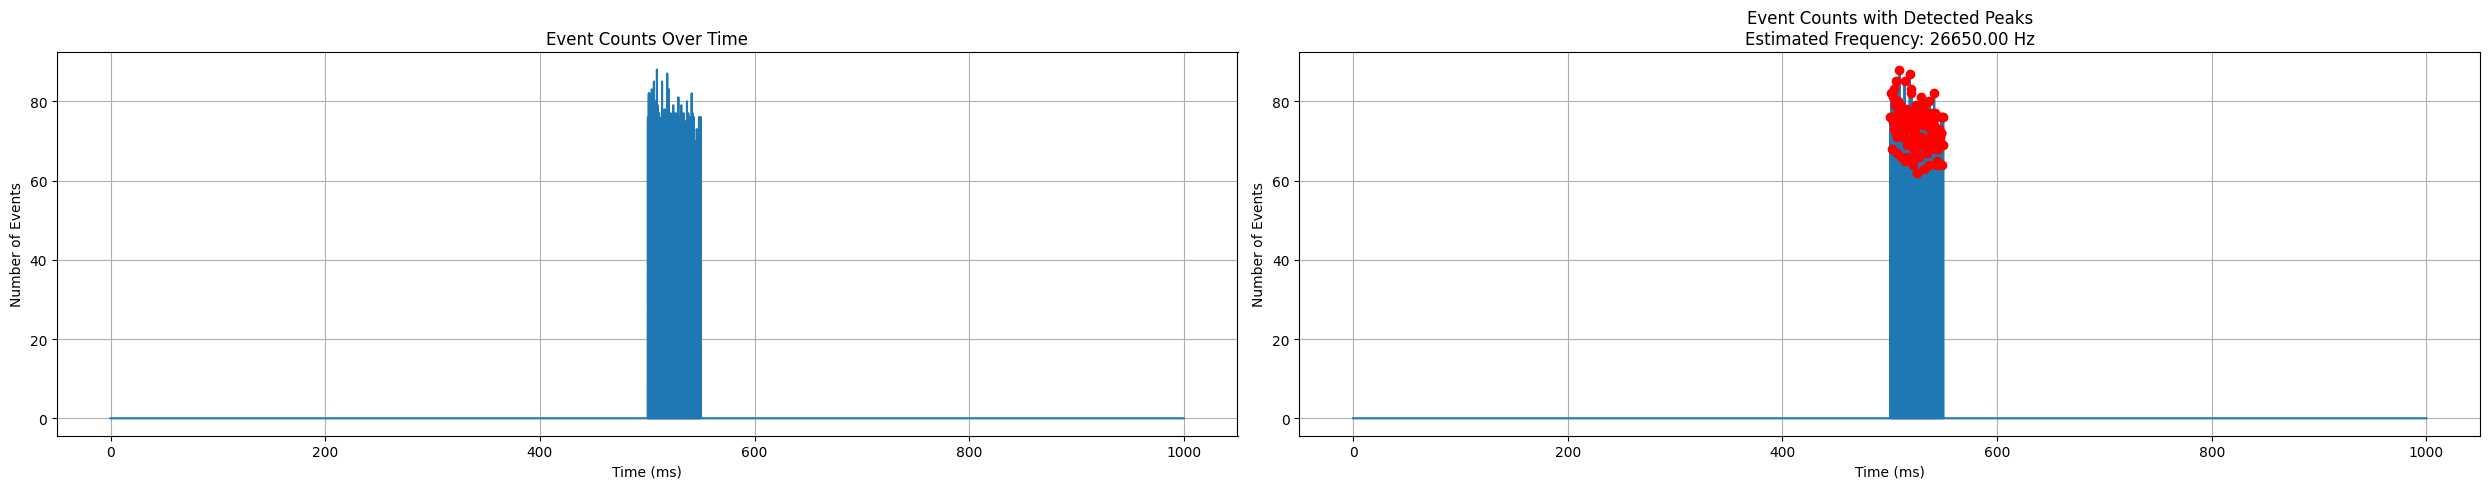

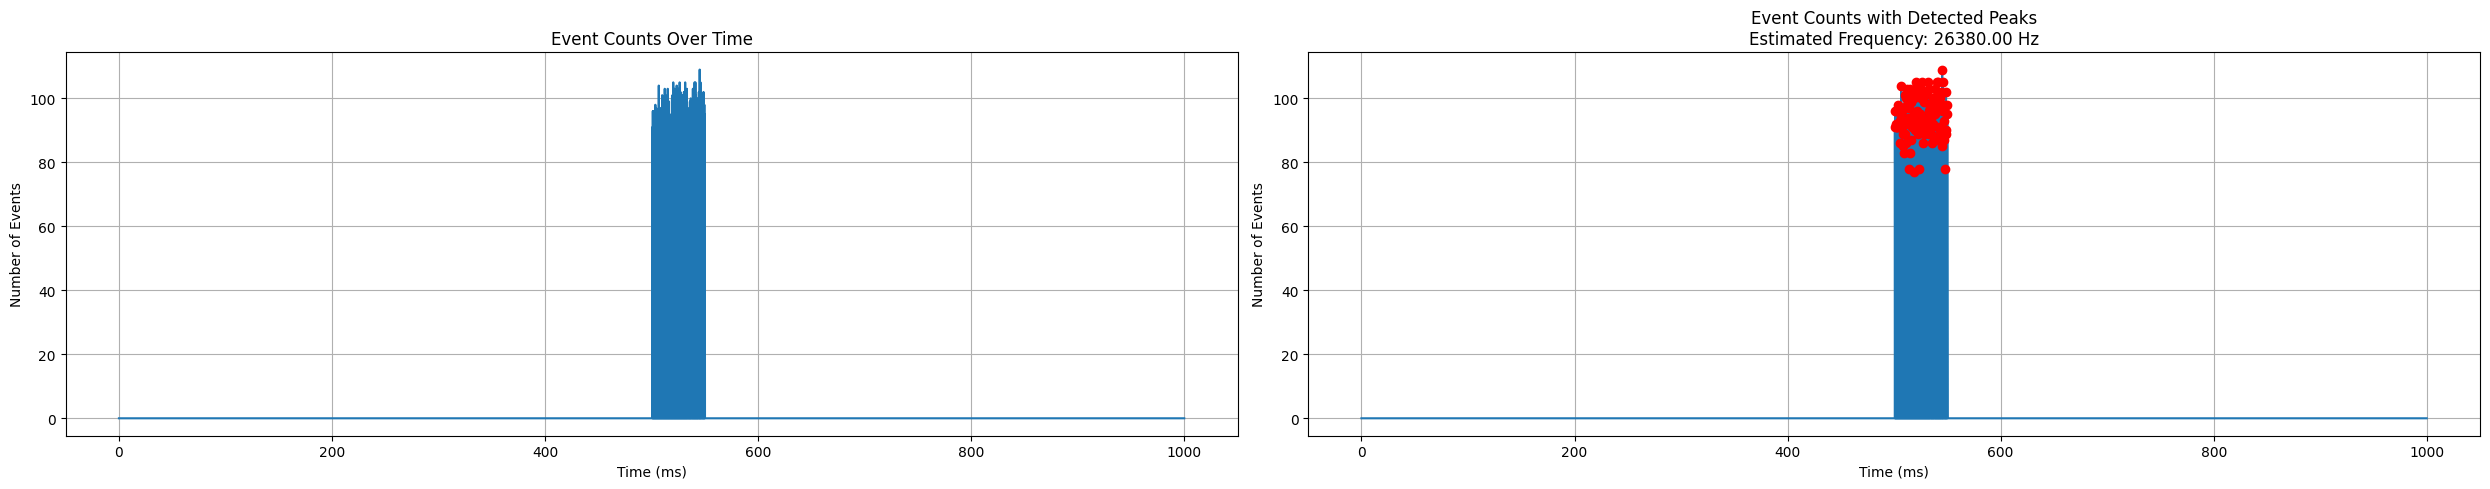

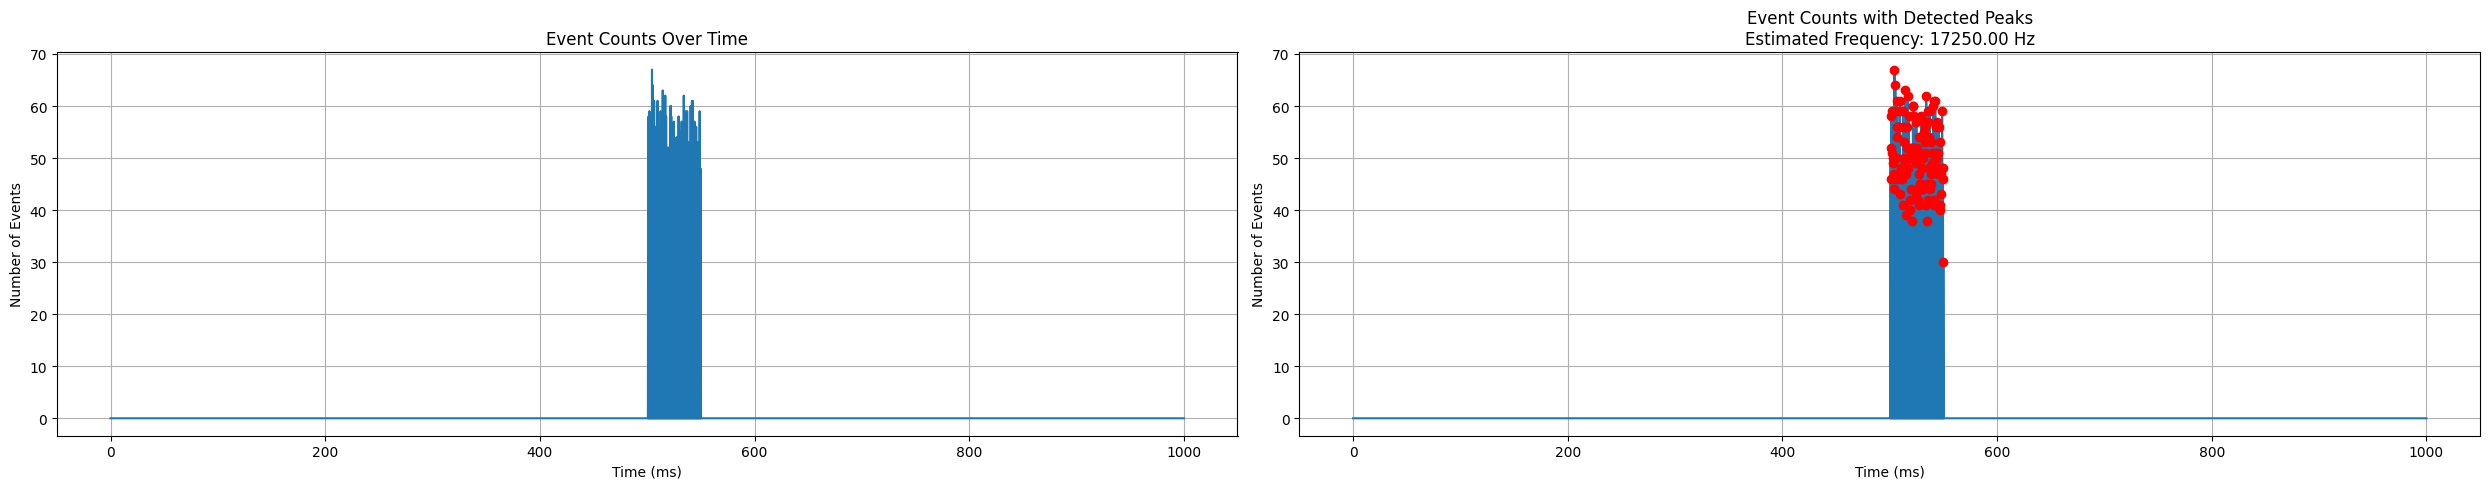

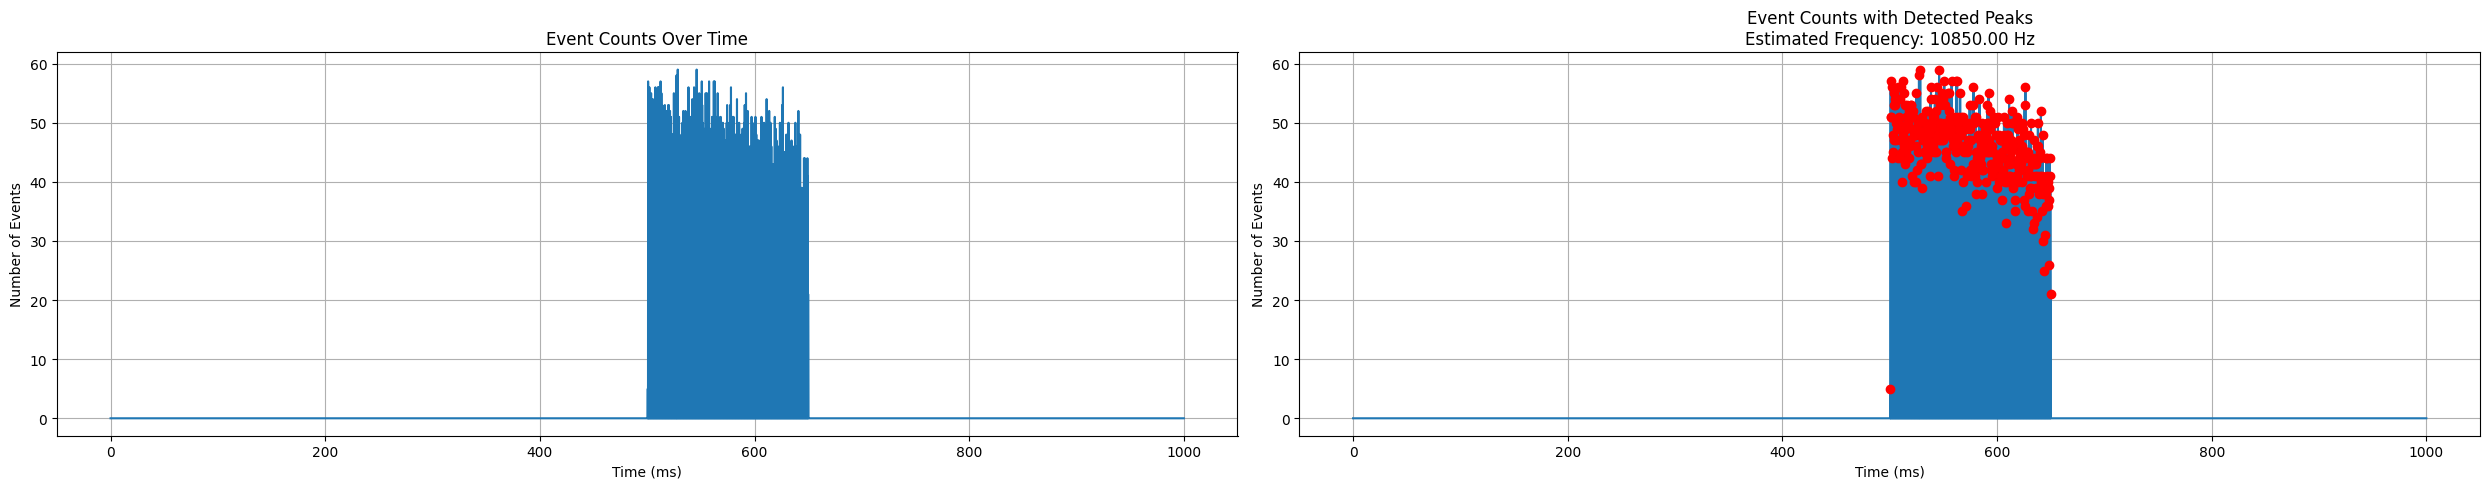

In [9]:
from plotting import create_combined_plot
from util import cut_timelt_events, estimate_frequency_from_raw, polarize_events
import numpy as np

p = 1

cut_time = 1000 #in us

pf_events_2_5k = [polarize_events(cut_timelt_events(x, cut_time), p) for x in f_events_2_5k]
pf_events_5k = [polarize_events(cut_timelt_events(x, cut_time), p) for x in f_events_5k]

dominant_freq_algo.compute_dominant_value(pf_events_2_5k[0])

freqs_2_5k = [estimate_frequency_from_raw(r, num_events=150000) for r in raws_2_5k]
freqs_5k = [estimate_frequency_from_raw(r, num_events=150000) for r in raws_5k]

for (x, f) in zip(pf_events_2_5k, freqs_2_5k):
	create_combined_plot(x, f)

for (x, f) in zip(pf_events_5k, freqs_5k):
	create_combined_plot(x, f)

### Testing the influence of distance on the event camera

In [10]:
freq = "100Hz"

paths = [
	["__100Hz", "0_5", "0", "recording_2024-10-02_11-54-06.raw"],
	["__100Hz", "1",   "0", "recording_2024-10-02_11-51-25.raw"],
	["__100Hz", "1_5", "0", "recording_2024-10-02_11-50-42.raw"],
	["__100Hz", "2",   "0", "recording_2024-10-02_11-48-38.raw"],
	["__100Hz", "2_5", "0", "recording_2024-10-02_11-47-56.raw"]
]

lables = [f"{(x + 1) * 0.5} m @ {freq}" for x in range(5)]

recordings = list(map(lambda x: os.path.join(dir_path, *x), paths))

raws = [RawReader(r) for r in recordings]

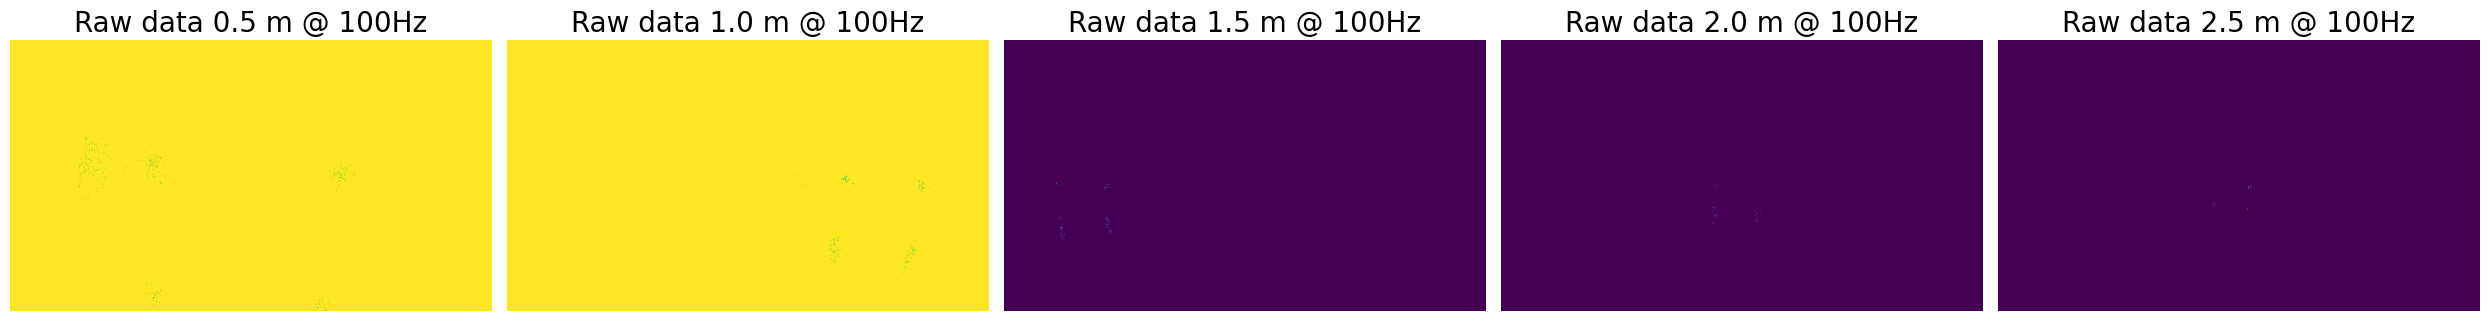

In [11]:
from plotting import visualize_data_raws

visualize_data_raws(raws, lables)